In [2]:
import pandas as pd
import numpy as np
import spacy
from spacy.lang.en import English
import nltk
import re
from absl import logging
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import os
import re
import seaborn as sns
import string
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [3]:
df = pd.read_csv('/Users/butler/Documents/GitHub/projects/Capstone_three/data/interim/gdeltproject_data_without_BBC')

In [4]:
df.head()

,Unnamed: 0,URL,Station,Show,IAShowID,IAPreviewThumb,Snippet,date
0,0,https://archive.org/details/MSNBC_20090702_180...,MSNBC,MSNBC News Live,MSNBC_20090702_180000_MSNBC_News_Live,https://archive.org/download/MSNBC_20090702_18...,represesentitis passed ann traordinary piece o...,2009-07-02 18:40:30
1,1,https://archive.org/details/MSNBC_20090702_190...,MSNBC,MSNBC News Live,MSNBC_20090702_190000_MSNBC_News_Live,https://archive.org/download/MSNBC_20090702_19...,ma a lf headway with th climate change bill an...,2009-07-02 19:51:52
2,2,https://archive.org/details/FOXNEWS_20090702_2...,FOXNEWS,Special Report With Bret Baier,FOXNEWS_20090702_221612_Special_Report_With_Br...,https://archive.org/download/FOXNEWS_20090702_...,they spent in the fat years money on such fash...,2009-07-02 22:54:51
3,3,https://archive.org/details/FOXNEWS_20090703_0...,FOXNEWS,The OReilly Factor,FOXNEWS_20090703_000000_The_OReilly_Factor,https://archive.org/download/FOXNEWS_20090703_...,"active? why not? no, we are not. nancy pelosi ...",2009-07-03 00:08:33
4,4,https://archive.org/details/FOXNEWS_20090703_0...,FOXNEWS,Greta Van Susteren,FOXNEWS_20090703_020000_Greta_Van_Susteren,https://archive.org/download/FOXNEWS_20090703_...,representative from washington state. he went ...,2009-07-03 02:44:09


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71598 entries, 0 to 71597
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      71598 non-null  int64 
 1   URL             71598 non-null  object
 2   Station         71598 non-null  object
 3   Show            71577 non-null  object
 4   IAShowID        71598 non-null  object
 5   IAPreviewThumb  71598 non-null  object
 6   Snippet         71598 non-null  object
 7   date            71598 non-null  object
dtypes: int64(1), object(7)
memory usage: 4.4+ MB


In [6]:
df.drop(['Unnamed: 0', 'URL', 'IAShowID', 'IAPreviewThumb'], axis=1, inplace=True)

In [7]:
df['date'] = pd.to_datetime(df['date'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71598 entries, 0 to 71597
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Station  71598 non-null  object        
 1   Show     71577 non-null  object        
 2   Snippet  71598 non-null  object        
 3   date     71598 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 2.2+ MB


In [9]:
df = df.rename({'Snippet': 'text'}, axis=1)

In [10]:
df.head()

,Station,Show,text,date
0,MSNBC,MSNBC News Live,represesentitis passed ann traordinary piece o...,2009-07-02 18:40:30
1,MSNBC,MSNBC News Live,ma a lf headway with th climate change bill an...,2009-07-02 19:51:52
2,FOXNEWS,Special Report With Bret Baier,they spent in the fat years money on such fash...,2009-07-02 22:54:51
3,FOXNEWS,The OReilly Factor,"active? why not? no, we are not. nancy pelosi ...",2009-07-03 00:08:33
4,FOXNEWS,Greta Van Susteren,representative from washington state. he went ...,2009-07-03 02:44:09


In [11]:
df['text_no_punct'] = df['Show'].copy()

In [12]:
for i in range(len(df)):
    lst = [x for x in df['text'].loc[i] if x not in string.punctuation]
    df['text_no_punct'].loc[i] = ''.join(lst)

/var/folders/nv/lggm200n09vgfy5n8_6lcz6c0000gn/T/ipykernel_3193/115077387.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_no_punct'].loc[i] = ''.join(lst)


In [13]:
df.head()

,Station,Show,text,date,text_no_punct
0,MSNBC,MSNBC News Live,represesentitis passed ann traordinary piece o...,2009-07-02 18:40:30,represesentitis passed ann traordinary piece o...
1,MSNBC,MSNBC News Live,ma a lf headway with th climate change bill an...,2009-07-02 19:51:52,ma a lf headway with th climate change bill an...
2,FOXNEWS,Special Report With Bret Baier,they spent in the fat years money on such fash...,2009-07-02 22:54:51,they spent in the fat years money on such fash...
3,FOXNEWS,The OReilly Factor,"active? why not? no, we are not. nancy pelosi ...",2009-07-03 00:08:33,active why not no we are not nancy pelosi went...
4,FOXNEWS,Greta Van Susteren,representative from washington state. he went ...,2009-07-03 02:44:09,representative from washington state he went t...


In [14]:
stopword_list = nltk.corpus.stopwords.words('english')

In [15]:
stopword_list.remove('no')

In [16]:
stopword_list.remove('not')

In [17]:
nlp = spacy.load("en_core_web_lg")

In [18]:
df['nlp'] = df['text_no_punct'].apply(lambda x: nlp(x))

In [19]:
df.head()

,Station,Show,text,date,text_no_punct,nlp
0,MSNBC,MSNBC News Live,represesentitis passed ann traordinary piece o...,2009-07-02 18:40:30,represesentitis passed ann traordinary piece o...,"(represesentitis, passed, ann, traordinary, pi..."
1,MSNBC,MSNBC News Live,ma a lf headway with th climate change bill an...,2009-07-02 19:51:52,ma a lf headway with th climate change bill an...,"(ma, a, lf, headway, with, th, climate, change..."
2,FOXNEWS,Special Report With Bret Baier,they spent in the fat years money on such fash...,2009-07-02 22:54:51,they spent in the fat years money on such fash...,"(they, spent, in, the, fat, years, money, on, ..."
3,FOXNEWS,The OReilly Factor,"active? why not? no, we are not. nancy pelosi ...",2009-07-03 00:08:33,active why not no we are not nancy pelosi went...,"(active, why, not, no, we, are, not, nancy, pe..."
4,FOXNEWS,Greta Van Susteren,representative from washington state. he went ...,2009-07-03 02:44:09,representative from washington state he went t...,"(representative, from, washington, state, he, ..."


In [20]:
df['entities'] = df['Show'].copy()
df['lemmas'] = df['Show'].copy()

for i in range(len(df)):
    df['lemmas'].loc[i] = [token.lemma_ for token in df['nlp'].loc[i]]
    lst = df['lemmas'].loc[i] 
    lst1 = [x for x in lst if x not in stopword_list]
    df['lemmas'].loc[i] = [x for x in lst1 if x not in string.punctuation]
    df['entities'].loc[i] = [(ent.text, ent.label_) for ent in df['nlp'].loc[i].ents]

/var/folders/nv/lggm200n09vgfy5n8_6lcz6c0000gn/T/ipykernel_3193/3188447351.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lemmas'].loc[i] = [token.lemma_ for token in df['nlp'].loc[i]]
/var/folders/nv/lggm200n09vgfy5n8_6lcz6c0000gn/T/ipykernel_3193/3188447351.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lemmas'].loc[i] = [x for x in lst1 if x not in string.punctuation]
/var/folders/nv/lggm200n09vgfy5n8_6lcz6c0000gn/T/ipykernel_3193/3188447351.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.o

In [21]:
df.head()

,Station,Show,text,date,text_no_punct,nlp,entities,lemmas
0,MSNBC,MSNBC News Live,represesentitis passed ann traordinary piece o...,2009-07-02 18:40:30,represesentitis passed ann traordinary piece o...,"(represesentitis, passed, ann, traordinary, pi...","[(represesentitis, NORP), (ann traordinary, PE...","[represesentitis, pass, ann, traordinary, piec..."
1,MSNBC,MSNBC News Live,ma a lf headway with th climate change bill an...,2009-07-02 19:51:52,ma a lf headway with th climate change bill an...,"(ma, a, lf, headway, with, th, climate, change...","[(democrats, NORP)]","[lf, headway, th, climate, change, bill, right..."
2,FOXNEWS,Special Report With Bret Baier,they spent in the fat years money on such fash...,2009-07-02 22:54:51,they spent in the fat years money on such fash...,"(they, spent, in, the, fat, years, money, on, ...","[(the fat years, DATE), (george bush, PERSON)]","[spend, fat, year, money, fashion, global, war..."
3,FOXNEWS,The OReilly Factor,"active? why not? no, we are not. nancy pelosi ...",2009-07-03 00:08:33,active why not no we are not nancy pelosi went...,"(active, why, not, no, we, are, not, nancy, pe...","[(china, GPE), (chinese, NORP)]","[active, not, no, not, nancy, pelosi, go, chin..."
4,FOXNEWS,Greta Van Susteren,representative from washington state. he went ...,2009-07-03 02:44:09,representative from washington state he went t...,"(representative, from, washington, state, he, ...","[(washington, GPE), (congress, ORG)]","[representative, washington, state, go, global..."


In [22]:
v = (df['nlp'].loc[0]).vector

In [23]:
columns = np.arange(0, 300)

In [24]:
vectors = pd.DataFrame(v.reshape(-1, len(v)),columns=columns)

In [25]:
vectors.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-1.585038,0.776908,-2.25324,0.631305,4.596736,0.284948,0.652779,4.046988,-0.277532,-1.109932,...,0.096414,0.243454,0.822692,-0.346068,-2.271298,0.45962,0.336875,-1.868874,-2.114235,0.358923


In [26]:
for i in range(1, len(df)):
    v = (df['nlp'].loc[i]).vector
    nv = pd.Series(v)
    
    vectors.loc[i] = nv 

KeyboardInterrupt: 

In [ ]:
vectors.head()

In [37]:
vectors.to_csv('/Users/butler/Documents/GitHub/projects/Capstone_three/data/interim/vectors_nlp_wo_punct_gdelt.csv')

In [33]:
inertia_values = []
sil_scores = []
for i in range(2,10):
    mod = KMeans(n_clusters=i, n_init='auto')
    mod.fit(vectors)
    inertia_values.append(mod.inertia_)
    labels = mod.predict(vectors)
    sil = silhouette_score(vectors, labels)
    sil_scores.append(sil)
    

In [34]:
inertia_values

[10448612.0,
 9920953.0,
 9498128.0,
 9214033.0,
 8995478.0,
 8812192.0,
 8652274.0,
 8537828.0]

In [35]:
sil_scores

[0.13500375,
 0.07658182,
 0.07424034,
 0.06930633,
 0.068085864,
 0.060544863,
 0.057681102,
 0.054166585]

In [27]:
vectors = pd.read_csv('/Users/butler/Documents/GitHub/projects/Capstone_three/data/interim/vectors_nlp_wo_punct_gdelt.csv')

In [82]:
vectors.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,0,-1.585038,0.776908,-2.253240,0.631305,4.596736,0.284948,0.652779,4.046989,-0.277532,...,0.096414,0.243454,0.822692,-0.346068,-2.271298,0.459620,0.336875,-1.868874,-2.114235,0.358923
1,1,-1.137692,2.322126,-3.371919,0.246694,1.783024,1.733879,-0.616709,3.581639,-2.359922,...,0.988488,-0.878835,0.388007,-0.393155,-1.158684,-0.008832,0.580320,-0.624207,-4.029707,2.954993
2,2,-2.229461,1.741505,-3.354967,0.352634,4.053811,-0.526949,0.254791,5.308504,-0.175237,...,0.817334,-0.677404,-0.080417,-0.548440,-2.242402,1.075100,1.240668,-1.518978,-3.097486,0.640433
3,3,-0.444676,2.887801,-2.746240,-0.910943,1.251352,0.618880,0.687496,3.574697,-2.568352,...,1.643914,-0.984649,0.360699,-1.773335,-1.172909,-1.527930,1.135828,0.220304,-3.823008,3.245398
4,4,-1.471585,0.892211,-3.039318,0.116040,4.098606,0.146115,-0.344206,5.607058,-0.857594,...,-0.068627,-1.390889,-1.582849,-1.197567,-2.232458,0.042879,0.568562,-0.946487,-4.293114,1.158995


In [83]:
vectors.drop(['Unnamed: 0'], axis=1, inplace=True)

In [84]:
mod = KMeans(n_clusters=2, n_init='auto')
mod.fit(vectors)

KMeans(n_clusters=2, n_init='auto')

In [85]:
df['labels_k_2'] = df['Show'].copy()

In [86]:
df['labels_k_2'] = mod.labels_

In [87]:
df.head()

,Station,Show,text,date,text_no_punct,nlp,entities,lemmas,labels_k_2,labels_k_3,hoax,deception,fraud,con,scam,ruse
0,MSNBC,MSNBC News Live,represesentitis passed ann traordinary piece o...,2009-07-02 18:40:30,represesentitis passed ann traordinary piece o...,"(represesentitis, passed, ann, traordinary, pi...","[(represesentitis, NORP), (ann traordinary, PE...","[represesentitis, pass, ann, traordinary, piec...",0,1,False,False,False,False,False,False
1,MSNBC,MSNBC News Live,ma a lf headway with th climate change bill an...,2009-07-02 19:51:52,ma a lf headway with th climate change bill an...,"(ma, a, lf, headway, with, th, climate, change...","[(democrats, NORP)]","[lf, headway, th, climate, change, bill, right...",1,1,False,False,False,False,False,False
2,FOXNEWS,Special Report With Bret Baier,they spent in the fat years money on such fash...,2009-07-02 22:54:51,they spent in the fat years money on such fash...,"(they, spent, in, the, fat, years, money, on, ...","[(the fat years, DATE), (george bush, PERSON)]","[spend, fat, year, money, fashion, global, war...",0,1,False,False,False,False,False,False
3,FOXNEWS,The OReilly Factor,"active? why not? no, we are not. nancy pelosi ...",2009-07-03 00:08:33,active why not no we are not nancy pelosi went...,"(active, why, not, no, we, are, not, nancy, pe...","[(china, GPE), (chinese, NORP)]","[active, not, no, not, nancy, pelosi, go, chin...",1,1,False,False,False,False,False,False
4,FOXNEWS,Greta Van Susteren,representative from washington state. he went ...,2009-07-03 02:44:09,representative from washington state he went t...,"(representative, from, washington, state, he, ...","[(washington, GPE), (congress, ORG)]","[representative, washington, state, go, global...",0,1,False,False,False,False,False,False


In [88]:
mod = KMeans(n_clusters=3, n_init='auto')
mod.fit(vectors)

KMeans(n_clusters=3, n_init='auto')

In [89]:
df['labels_k_3'] = df['Show'].copy()

In [90]:
df['labels_k_3'] = mod.labels_

In [91]:
df.head()

,Station,Show,text,date,text_no_punct,nlp,entities,lemmas,labels_k_2,labels_k_3,hoax,deception,fraud,con,scam,ruse
0,MSNBC,MSNBC News Live,represesentitis passed ann traordinary piece o...,2009-07-02 18:40:30,represesentitis passed ann traordinary piece o...,"(represesentitis, passed, ann, traordinary, pi...","[(represesentitis, NORP), (ann traordinary, PE...","[represesentitis, pass, ann, traordinary, piec...",0,2,False,False,False,False,False,False
1,MSNBC,MSNBC News Live,ma a lf headway with th climate change bill an...,2009-07-02 19:51:52,ma a lf headway with th climate change bill an...,"(ma, a, lf, headway, with, th, climate, change...","[(democrats, NORP)]","[lf, headway, th, climate, change, bill, right...",1,1,False,False,False,False,False,False
2,FOXNEWS,Special Report With Bret Baier,they spent in the fat years money on such fash...,2009-07-02 22:54:51,they spent in the fat years money on such fash...,"(they, spent, in, the, fat, years, money, on, ...","[(the fat years, DATE), (george bush, PERSON)]","[spend, fat, year, money, fashion, global, war...",0,2,False,False,False,False,False,False
3,FOXNEWS,The OReilly Factor,"active? why not? no, we are not. nancy pelosi ...",2009-07-03 00:08:33,active why not no we are not nancy pelosi went...,"(active, why, not, no, we, are, not, nancy, pe...","[(china, GPE), (chinese, NORP)]","[active, not, no, not, nancy, pelosi, go, chin...",1,0,False,False,False,False,False,False
4,FOXNEWS,Greta Van Susteren,representative from washington state. he went ...,2009-07-03 02:44:09,representative from washington state he went t...,"(representative, from, washington, state, he, ...","[(washington, GPE), (congress, ORG)]","[representative, washington, state, go, global...",0,2,False,False,False,False,False,False


Text(0, 0.5, 'Number Data Points')

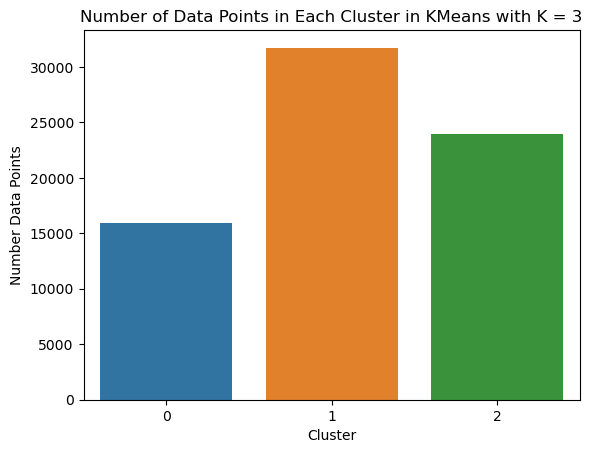

In [92]:
ax = sns.barplot(x=[0,1,2], y=np.bincount(mod.labels_))
ax.set_title('Number of Data Points in Each Cluster in KMeans with K = 3')
ax.set_xlabel('Cluster')
ax.set_ylabel('Number Data Points')

In [93]:
df['hoax'] = df['Show'].copy()
for i in range(len(df)):
    if 'hoax' in df['lemmas'].loc[i]:
        
        df['hoax'].loc[i] = True
    else:
        df['hoax'].loc[i] = False

/var/folders/nv/lggm200n09vgfy5n8_6lcz6c0000gn/T/ipykernel_3193/2896022161.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hoax'].loc[i] = False
/var/folders/nv/lggm200n09vgfy5n8_6lcz6c0000gn/T/ipykernel_3193/2896022161.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hoax'].loc[i] = True


In [94]:
df['deception'] = df['Show'].copy()
for i in range(len(df)):
    if 'deception' in df['lemmas'].loc[i]:
        
        df['deception'].loc[i] = True
    else:
        df['deception'].loc[i] = False

/var/folders/nv/lggm200n09vgfy5n8_6lcz6c0000gn/T/ipykernel_3193/643027619.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['deception'].loc[i] = False
/var/folders/nv/lggm200n09vgfy5n8_6lcz6c0000gn/T/ipykernel_3193/643027619.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['deception'].loc[i] = True


In [95]:
df['fraud'] = df['Show'].copy()
for i in range(len(df)):
    if 'fraud' in df['lemmas'].loc[i]:
        
        df['fraud'].loc[i] = True
    else:
        df['fraud'].loc[i] = False

/var/folders/nv/lggm200n09vgfy5n8_6lcz6c0000gn/T/ipykernel_3193/3788480606.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fraud'].loc[i] = False
/var/folders/nv/lggm200n09vgfy5n8_6lcz6c0000gn/T/ipykernel_3193/3788480606.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fraud'].loc[i] = True


In [135]:
fraud_list = df[df['fraud'] == True].index.to_list()

In [136]:
hoax_list = df[df['hoax'] == True].index.to_list()

In [137]:
deception_list = df[df['deception'] == True].index.to_list()

In [138]:
lst_0 = df[df['labels_k_3'] == 0].index.to_list()

In [139]:
lst_1 = df[df['labels_k_3'] == 1].index.to_list()

In [140]:
lst_2 = df[df['labels_k_3'] == 2].index.to_list()

In [141]:
hoax_0 = [x for x in lst_0 if x in hoax_list]

In [142]:
len(hoax_0)

356

In [143]:
hoax_1 = [x for x in lst_1 if x in hoax_list]

In [144]:
len(hoax_1)

696

In [145]:
hoax_2 = [x for x in lst_2 if x in hoax_list]

In [146]:
len(hoax_2)

433

In [147]:
fraud_0 = [x for x in lst_0 if x in fraud_list]

In [148]:
len(fraud_0)

29

In [149]:
fraud_1 = [x for x in lst_1 if x in fraud_list]

In [150]:
len(fraud_1)

44

In [151]:
fraud_2 = [x for x in lst_0 if x in fraud_list]

In [152]:
len(fraud_2)

29

In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71598 entries, 0 to 71597
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Station        71598 non-null  object        
 1   Show           71577 non-null  object        
 2   text           71598 non-null  object        
 3   date           71598 non-null  datetime64[ns]
 4   text_no_punct  71598 non-null  object        
 5   nlp            71598 non-null  object        
 6   entities       71598 non-null  object        
 7   lemmas         71598 non-null  object        
 8   labels_k_2     71598 non-null  int32         
 9   labels_k_3     71598 non-null  int32         
 10  hoax           71598 non-null  object        
 11  deception      71598 non-null  object        
 12  fraud          71598 non-null  object        
 13  con            71598 non-null  object        
 14  scam           71598 non-null  object        
 15  ruse           7159

In [154]:
df['con'] = df['Show'].copy()
for i in range(len(df)):
    if 'con' in df['lemmas'].loc[i]:
        
        df['con'].loc[i] = True
    else:
        df['con'].loc[i] = False

/var/folders/nv/lggm200n09vgfy5n8_6lcz6c0000gn/T/ipykernel_3193/4142467073.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['con'].loc[i] = False
/var/folders/nv/lggm200n09vgfy5n8_6lcz6c0000gn/T/ipykernel_3193/4142467073.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['con'].loc[i] = True


In [155]:
con_list = df[df['con'] == True].index.to_list()

In [156]:
con_0 = [x for x in lst_0 if x in con_list]

In [157]:
len(con_0)

29

In [158]:
con_1 = [x for x in lst_1 if x in con_list]

In [159]:
len(con_1)

29

In [160]:
con_2 = [x for x in lst_2 if x in con_list]

In [120]:
len(con_2)

20

In [62]:
df['scam'] = df['Show'].copy()
for i in range(len(df)):
    if 'scam' in df['lemmas'].loc[i]:
        
        df['scam'].loc[i] = True
    else:
        df['scam'].loc[i] = False

/var/folders/nv/lggm200n09vgfy5n8_6lcz6c0000gn/T/ipykernel_3193/3041829891.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['scam'].loc[i] = False
/var/folders/nv/lggm200n09vgfy5n8_6lcz6c0000gn/T/ipykernel_3193/3041829891.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['scam'].loc[i] = True


In [69]:
scam_list = df[df['scam'] == True].index.to_list()

In [121]:
scam_0 = [x for x in lst_0 if x in scam_list]

In [123]:
len(scam_0)

13

In [124]:
scam_1 = [x for x in lst_1 if x in scam_list]

In [125]:
len(scam_1)

29

In [126]:
scam_2 = [x for x in lst_2 if x in scam_list]

In [127]:
len(scam_2)

15

In [71]:
df['ruse'] = df['Show'].copy()
for i in range(len(df)):
    if 'ruse' in df['lemmas'].loc[i]:
        
        df['ruse'].loc[i] = True
    else:
        df['ruse'].loc[i] = False

/var/folders/nv/lggm200n09vgfy5n8_6lcz6c0000gn/T/ipykernel_3193/1861019757.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ruse'].loc[i] = False
/var/folders/nv/lggm200n09vgfy5n8_6lcz6c0000gn/T/ipykernel_3193/1861019757.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ruse'].loc[i] = True


In [162]:
df.head()

,Station,Show,text,date,text_no_punct,nlp,entities,lemmas,labels_k_2,labels_k_3,hoax,deception,fraud,con,scam,ruse
0,MSNBC,MSNBC News Live,represesentitis passed ann traordinary piece o...,2009-07-02 18:40:30,represesentitis passed ann traordinary piece o...,"(represesentitis, passed, ann, traordinary, pi...","[(represesentitis, NORP), (ann traordinary, PE...","[represesentitis, pass, ann, traordinary, piec...",0,2,False,False,False,False,False,False
1,MSNBC,MSNBC News Live,ma a lf headway with th climate change bill an...,2009-07-02 19:51:52,ma a lf headway with th climate change bill an...,"(ma, a, lf, headway, with, th, climate, change...","[(democrats, NORP)]","[lf, headway, th, climate, change, bill, right...",1,1,False,False,False,False,False,False
2,FOXNEWS,Special Report With Bret Baier,they spent in the fat years money on such fash...,2009-07-02 22:54:51,they spent in the fat years money on such fash...,"(they, spent, in, the, fat, years, money, on, ...","[(the fat years, DATE), (george bush, PERSON)]","[spend, fat, year, money, fashion, global, war...",0,2,False,False,False,False,False,False
3,FOXNEWS,The OReilly Factor,"active? why not? no, we are not. nancy pelosi ...",2009-07-03 00:08:33,active why not no we are not nancy pelosi went...,"(active, why, not, no, we, are, not, nancy, pe...","[(china, GPE), (chinese, NORP)]","[active, not, no, not, nancy, pelosi, go, chin...",1,0,False,False,False,False,False,False
4,FOXNEWS,Greta Van Susteren,representative from washington state. he went ...,2009-07-03 02:44:09,representative from washington state he went t...,"(representative, from, washington, state, he, ...","[(washington, GPE), (congress, ORG)]","[representative, washington, state, go, global...",0,2,False,False,False,False,False,False


In [73]:
ruse_list = df[df['ruse'] == True].index.to_list()

In [128]:
ruse_0 = [x for x in lst_0 if x in ruse_list]

In [129]:
len(ruse_0)

0

In [130]:
ruse_1 = [x for x in lst_1 if x in ruse_list]

In [132]:
len(ruse_1)

1

In [133]:
ruse_2 = [x for x in lst_2 if x in ruse_list]

In [134]:
len(ruse_2)

0

In [163]:
df.to_csv('/Users/butler/Documents/GitHub/projects/Capstone_three/data/interim/nlp_wo_punct_gdelt.csv')